Name: Hanish Sai Rohit
Ph no: 8332082623
email: hanishsidhu@gmail.com
email: hanishrohit@gmail.com

# Stack Overflow: Tag Prediction

In [1]:
import os
from sqlalchemy import create_engine 
from datetime import datetime
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import SGDClassifier
from datetime import datetime
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from tqdm import tqdm
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import seaborn as sns

<h1>  Business Problem </h1>

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<h2> Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h2> Data </h2>

<h3> Data Overview </h3>

__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2> Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
</p>

<h3> Performance metric </h3>

<b> Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>


<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted

# Data Aquisition

In [47]:
if not os.path.isfile('stack_overflow_final.db'):
    start = datetime.now()
    disk_engine = create_engine("sqlite:///stack_overflow_final.db")
    chuncksize = 100000
    j = 0
    dataframe_size = 0
    index_start = 1
    for train in pd.read_csv("train.csv",names=['Id', 'Title', 'Body', 'Tags'], chunksize=chuncksize, iterator=True, encoding='utf-8'):
        train.index += index_start
        j = j + 1
        train.to_sql('data',disk_engine,if_exists ='append')
        dataframe_size = dataframe_size + len(train.index)
        #loading only 0.5 Million data points due to the limitation of having 4 GB RAM 
        if dataframe_size == 500000:
            break
    index_start = train.index[-1] + 1
    
print("time taken to load data",datetime.now() - start)

time taken to load data 0:00:19.048411


In [86]:
if os.path.isfile('stack_overflow_final.db'):
    start = datetime.now()
    con = sqlite3.connect('stack_overflow_final.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database         :",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)

Number of rows in the database         : 500000
Time taken to count the number of rows : 0:00:00.493328


### Checking for duplicates 

In [15]:
import sqlite3

if os.path.isfile('stack_overflow_final.db'):
    start = datetime.now()
    con = sqlite3.connect('stack_overflow_final.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags ', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:23.262048


In [5]:
print("number of duplicate questions :", 500000 - df_no_dup.shape[0], "(",(1-(df_no_dup.shape[0]/500000))*100,"% )")

number of duplicate questions : 14164 ( 2.832800000000002 % )


In [6]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = (["number of times a question appeared in database ", "number of questions"])

i = df_no_dup.cnt_dup.value_counts().index
count =0
for num in df_no_dup.cnt_dup.value_counts() :
    x.add_row([i[count],num])
    count = count + 1
    
print(x)

+--------------------------------------------------+---------------------+
| number of times a question appeared in database  | number of questions |
+--------------------------------------------------+---------------------+
|                        1                         |        471818       |
|                        2                         |        13872        |
|                        3                         |         146         |
+--------------------------------------------------+---------------------+


In [7]:
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
df_no_dup.head()

,Title,Body,Tags,cnt_dup,tag_count
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1,2
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1,3
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1,1
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,2,2


In [8]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = (["number of tags for a question", "number of questions"])

i = df_no_dup.tag_count.value_counts().index
count =0
for num in df_no_dup.tag_count.value_counts() :
    x.add_row([i[count],num])
    count = count + 1
    
print(x)

+-------------------------------+---------------------+
| number of tags for a question | number of questions |
+-------------------------------+---------------------+
|               3               |        139064       |
|               2               |        129207       |
|               4               |        93550        |
|               1               |        66624        |
|               5               |        57391        |
+-------------------------------+---------------------+


In [87]:
#Creating a new database with no duplicates
if not os.path.isfile('no_dup.db'):
    disk_dup = create_engine("sqlite:///no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup',disk_dup)

# Data Analysis of Tags 

In [9]:
if os.path.isfile('no_dup.db'):
    con = sqlite3.connect('no_dup.db')
    no_duplicates_tags_df = pd.read_sql_query("SELECT Tags FROM no_dup",con)
    con.close()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(no_duplicates_tags_df['Tags'])

print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 485836
Number of unique tags : 30429


In [14]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tag_names, freqs))

In [118]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tag_names, freqs))

In [15]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


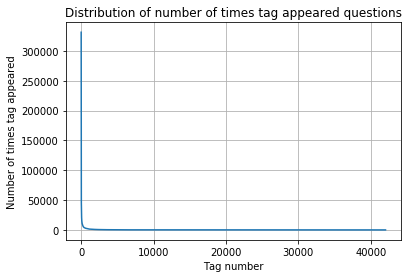

In [16]:
tag_df_sorted = tag_df.sort_values(['Counts'],ascending =False)
tag_counts = tag_df_sorted['Counts'].values
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

observation:
    * a very few tags occurred more number of times.

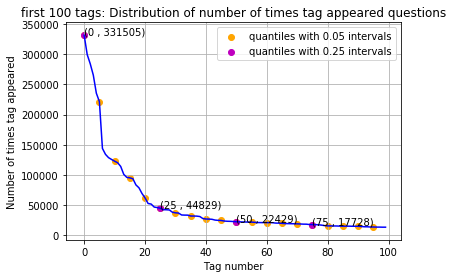

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [17]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

observation:
    * The most occurred tag had occurred 331505 times.
    * The second most occurred tag had occurred 221533 times.

In [19]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))


We have total 485836 datapoints.


In [21]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.888598


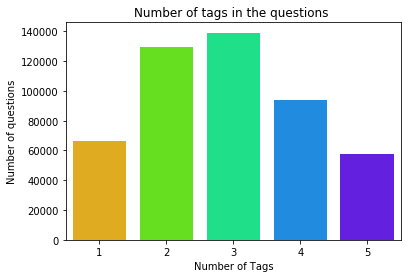

In [23]:
import seaborn as sns
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

observation:
    * maximum number of questions have 3 tags.
    * minimum number of questions have 5 tags.

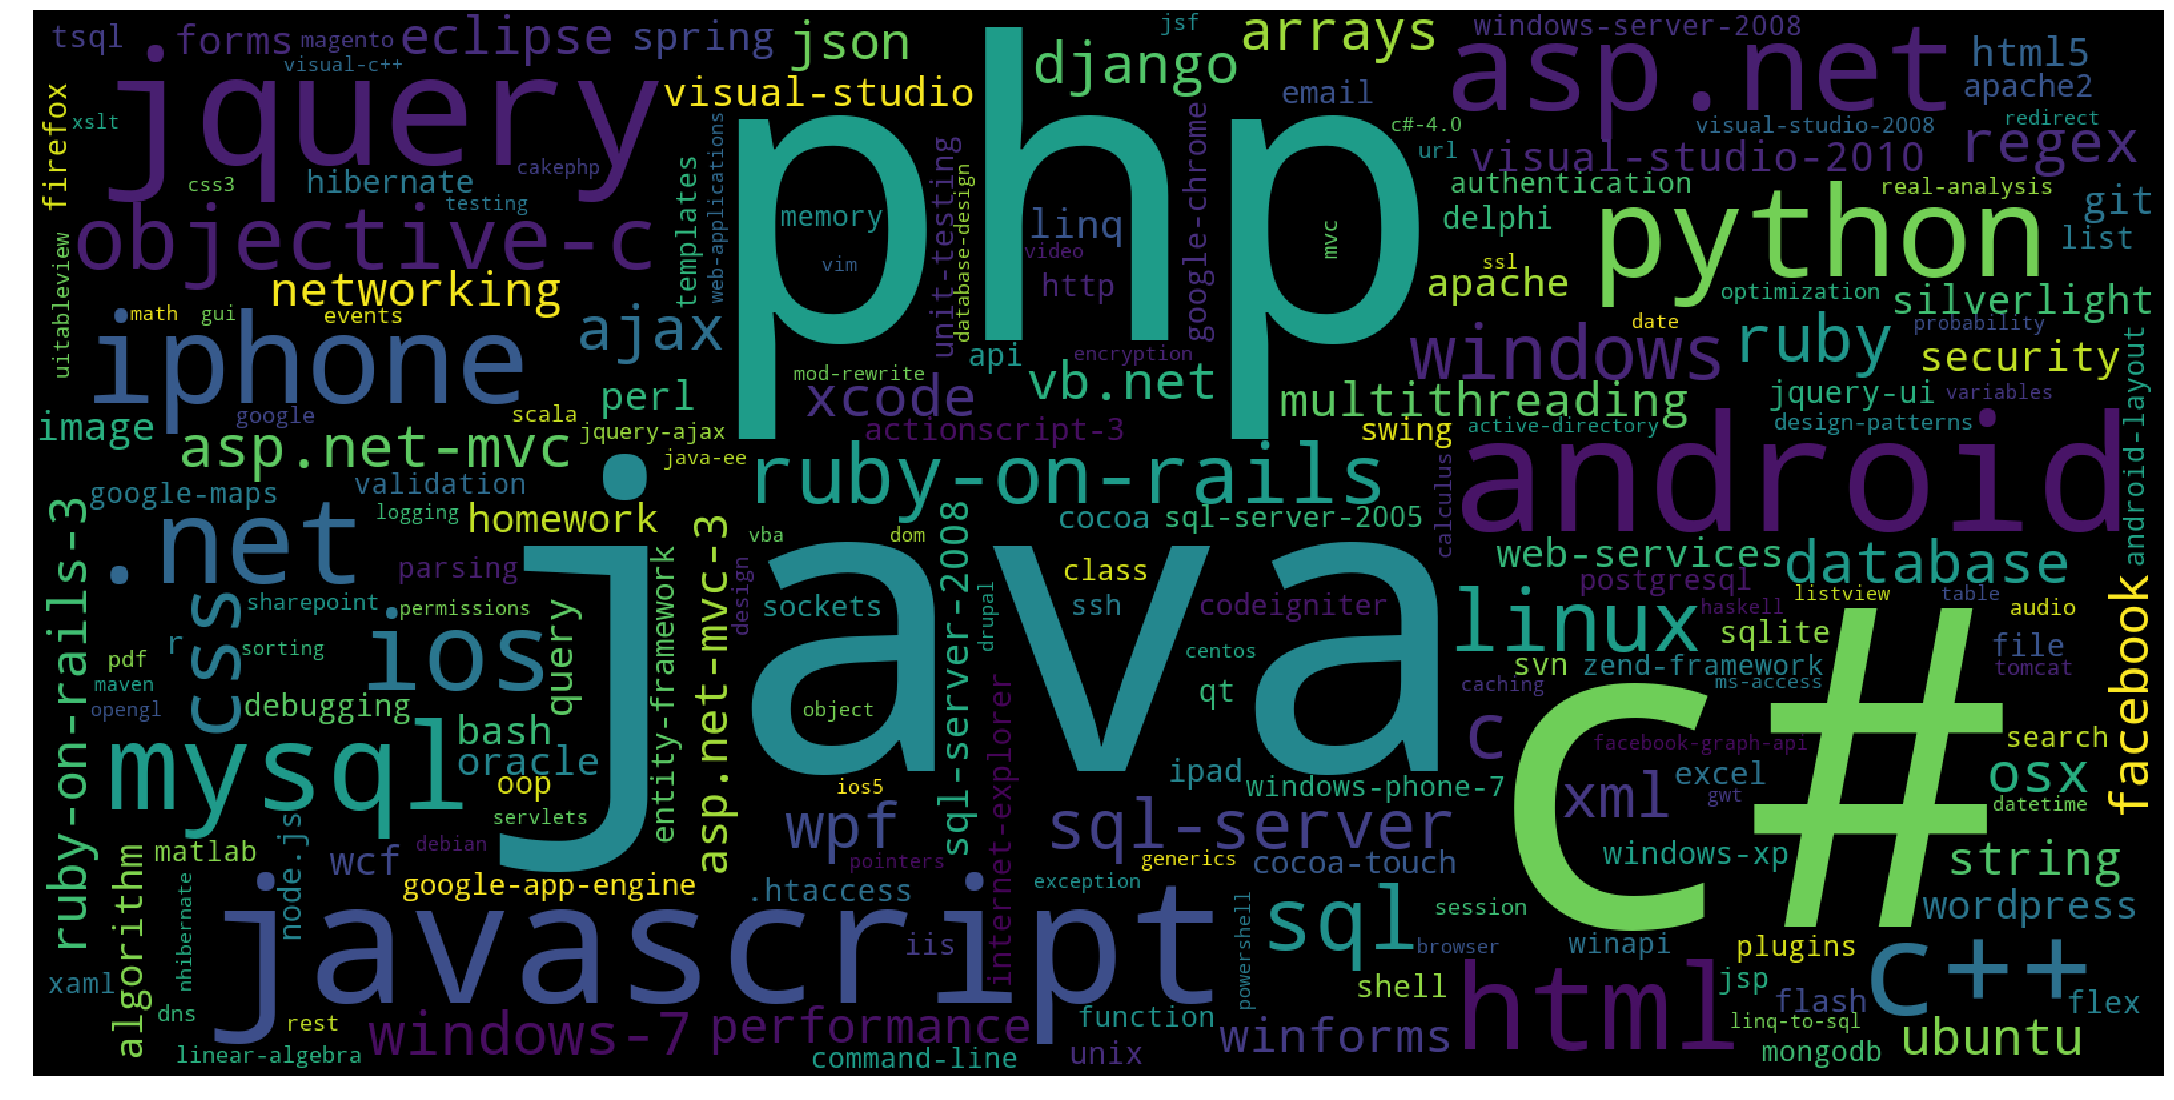

Time taken to run this cell : 0:00:05.825055


In [24]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

observation: 
    * most occuring tags are programming languages like C#,Java,php,python

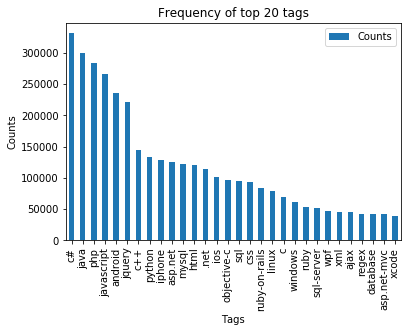

In [26]:
import numpy as np
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

# Data Cleaning - Questions

In [2]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# a function to clean html in the data

def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
#stemmer to stem all the similar words

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    tables =table_names.fetchall() 
    print("Tables in the databse : ",tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse :  QuestionsProcessed


In [47]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
read_db = 'no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup ")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 0")

Tables in the databse :  QuestionsProcessed


In [48]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
import re
from nltk.tokenize import word_tokenize
#import nltk
#nltk.download('punkt')

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
Avg. length of questions(Title+Body) before processing: 1150
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 56
Time taken to run this cell : 0:14:56.833735


In [54]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()
print("total numner of questions processed",questions_proccesed+1)

total numner of questions processed 485836


In [55]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [57]:
print("Questions after preprocessed")
print('='*100)

for r in range(0,2):
    print(preprocessed_data['question'].iloc[r])
    print('-'*100)

Questions after preprocessed
continu function show lim alpha int frac alpha alpha let continu function alpha gt love help find follow limit lim alpha int frac alpha first tri bound function sinc continu close interv lim alpha int frac alpha leq lim alpha int frac alpha get number depend alpha assum integr alway diverg sinc continu divid expon bigger one multipli infti mayb use hopit somehow thank
----------------------------------------------------------------------------------------------------
except prelud read pars haskel pars express recurs portion code read two number main io function omit give sum ration use later multipl oper second error pars function unabl handl look data ratio page web solut found would appreci help thank csjc
----------------------------------------------------------------------------------------------------


# Data Analysis of Questions

In [46]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ([" Question ","Tags"])

for i in range(0,8,2):
    
    a =df_no_dup['Title'].iloc[i]
    b =df_no_dup['Tags'].iloc[i]
    
    x.add_row([a,b])

print(x)

+----------------------------------------------------------------------------------------+----------------------------+
|                                        Question                                        |            Tags            |
+----------------------------------------------------------------------------------------+----------------------------+
|              "SQL Injection" issue preventing correct form submission - PHP            |         php forms          |
|  *** Exception: Prelude.read: no parse in Haskell - Parsing, Expressions and Recursion | parsing haskell expression |
|            Accessing @Local Session Bean from an exposed RESTeasy interface            |        ejb resteasy        |
|               Automatic data recognition and plot processing in pgfplots               |          pgfplots          |
+----------------------------------------------------------------------------------------+----------------------------+


observation:
    * two questions have all of their corresponding tags present in the question's title.
    * two questions have few of their corresponding tags present in the question's title. 

## Analysing the average number of tags that are present in a question

In [50]:
from fuzzywuzzy import fuzz
from tqdm import tqdm

count_100 =0
count_75=0
count_50 =0
count_25 =0
for i in tqdm(range(0,df_no_dup.shape[0])):
    sim_tag_qn = fuzz.token_set_ratio(df_no_dup['Title'].iloc[i],df_no_dup['Tags'].iloc[i])
    
    #fuzz.token_set_ratio score will tell us how many tags that are actually present in the title
    
    if sim_tag_qn == 100:
        count_100 = count_100 + 1
    if sim_tag_qn >74:
        count_75 = count_75 + 1
    if sim_tag_qn >49:
        count_50 = count_50 + 1
    if sim_tag_qn > 24:
        count_25 = count_25 + 1


100%|██████████| 485836/485836 [00:47<00:00, 10253.92it/s]


In [51]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ([" % of questions"," token set ratio score between Title and Tags "])

x.add_row([np.round((count_100/df_no_dup.shape[0])*100,decimals=2),"equal to 100"])
x.add_row([np.round((count_75/df_no_dup.shape[0])*100,decimals=2),"more than 74"])
x.add_row([np.round((count_50/df_no_dup.shape[0])*100,decimals=2),"more than 49"])
x.add_row([np.round((count_25/df_no_dup.shape[0])*100,decimals=2),"more than 24"])

    
print(x)

+-----------------+------------------------------------------------+
|  % of questions |  token set ratio score between Title and Tags  |
+-----------------+------------------------------------------------+
|      14.29      |                  equal to 100                  |
|      29.72      |                  more than 74                  |
|      63.12      |                  more than 49                  |
|      91.79      |                  more than 24                  |
+-----------------+------------------------------------------------+


observation:
    * 14% of questions have all of their corresponding tags present in the title
    * 63% of questions have half of their corresponding tags present in the title.

In [52]:
count_100 =0
count_75=0
count_50 =0
count_25 =0
for i in tqdm(range(0,df_no_dup.shape[0])):
    sim_tag_qn = fuzz.token_set_ratio(df_no_dup['Title'].iloc[i] + df_no_dup['Body'].iloc[i],df_no_dup['Tags'].iloc[i])
    
    #fuzz.token_set_ratio score will tell us how many tags that are actually present in the title & body 
    
    if sim_tag_qn == 100:
        count_100 = count_100 + 1
    if sim_tag_qn >74:
        count_75 = count_75 + 1
    if sim_tag_qn >49:
        count_50 = count_50 + 1
    if sim_tag_qn > 24:
        count_25 = count_25 + 1


100%|██████████| 485836/485836 [02:45<00:00, 2942.16it/s]


In [53]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ([" % of questions"," token set ratio score between (Title + body) and Tags "])

x.add_row([np.round((count_100/df_no_dup.shape[0])*100,decimals=2),"equal to 100"])
x.add_row([np.round((count_75/df_no_dup.shape[0])*100,decimals=2),"more than 74"])
x.add_row([np.round((count_50/df_no_dup.shape[0])*100,decimals=2),"more than 49"])
x.add_row([np.round((count_25/df_no_dup.shape[0])*100,decimals=2),"more than 24"])

    
print(x)

+-----------------+---------------------------------------------------------+
|  % of questions |  token set ratio score between (Title + body) and Tags  |
+-----------------+---------------------------------------------------------+
|       31.4      |                       equal to 100                      |
|      55.21      |                       more than 74                      |
|      78.33      |                       more than 49                      |
|      88.97      |                       more than 24                      |
+-----------------+---------------------------------------------------------+


observation:
    * 31% of questions have all their tags present in the title and body.
    * 78% of questions have half of their tags present in the title and body.

In [62]:
count_100 =0
count_75=0
count_50 =0

for i in tqdm(range(0,10)):
    for j in range(0,tag_df.shape[0]):
        sim_tag_qn = fuzz.token_set_ratio(df_no_dup['Title'].iloc[i],df_no_dup['Tags'].iloc[j])
        
        #fuzz.token_set_ratio score will tell us how many tags that are actually present in the title
        if sim_tag_qn == 100:
            count_100 = count_100 + 1
        if sim_tag_qn >74:
            count_75 = count_75 + 1
        if sim_tag_qn >49:
            count_50 = count_50 + 1



100%|██████████| 10/10 [00:39<00:00,  3.68s/it]


In [63]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = (["percentage of tags"," token set ratio score of a question's title with all tags in dataset"])

x.add_row([np.round((count_100/(tag_df.shape[0]*10))*100,decimals =2),"equal to 100"])
x.add_row([np.round((count_75/(tag_df.shape[0]*10))*100,decimals =2),"more than 74"])
x.add_row([np.round((count_50/(tag_df.shape[0]*10))*100,decimals =2),"more than 49"])

    
print(x)

+--------------------+-----------------------------------------------------------------------+
| percentage of tags |  token set ratio score of a question's title with all tags in dataset |
+--------------------+-----------------------------------------------------------------------+
|        0.13        |                              equal to 100                             |
|        0.29        |                              more than 74                             |
|        1.13        |                              more than 49                             |
+--------------------+-----------------------------------------------------------------------+


observation:
    * a very few number of all the tags in a dataset are present in a question's title.

In [64]:
count_100 =0
count_75=0
count_50 =0

for i in tqdm(range(0,10)):
    for j in range(0,tag_df.shape[0]):
        sim_tag_qn = fuzz.token_set_ratio(df_no_dup['Title'].iloc[i]+ df_no_dup['Body'].iloc[i],df_no_dup['Tags'].iloc[j])
        
        #fuzz.token_set_ratio score will tell us how many tags that are actually present in the title
        if sim_tag_qn == 100:
            count_100 = count_100 + 1
        if sim_tag_qn >74:
            count_75 = count_75 + 1
        if sim_tag_qn >49:
            count_50 = count_50 + 1

100%|██████████| 10/10 [02:47<00:00, 14.36s/it]


In [65]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = (["percentage of tags"," token set ratio score of a question's title and body with all tags in dataset"])

x.add_row([np.round((count_100/(tag_df.shape[0]*10))*100,decimals =2),"equal to 100"])
x.add_row([np.round((count_75/(tag_df.shape[0]*10))*100,decimals =2),"more than 74"])
x.add_row([np.round((count_50/(tag_df.shape[0]*10))*100,decimals =2),"more than 49"])

    
print(x)

+--------------------+--------------------------------------------------------------------------------+
| percentage of tags |  token set ratio score of a question's title and body with all tags in dataset |
+--------------------+--------------------------------------------------------------------------------+
|        0.49        |                                  equal to 100                                  |
|        0.74        |                                  more than 74                                  |
|        2.11        |                                  more than 49                                  |
+--------------------+--------------------------------------------------------------------------------+


observation:
    * a very few number of all the tags in a dataset are present in a question's title and body.

In [11]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
question_vector = vectorizer.fit_transform(preprocessed_data['question'])
unique_words = vectorizer.get_feature_names()
idf_values = vectorizer.idf_

In [75]:
word_idf_df = pd.concat([pd.DataFrame(unique_words,columns =['word']),pd.DataFrame(idf_values,columns=['idf'])],axis =1)
sorted_word_idf_df = word_idf_df.sort_values(by=['idf'])

In [76]:
sorted_word_idf_df = sorted_word_idf_df.reset_index()

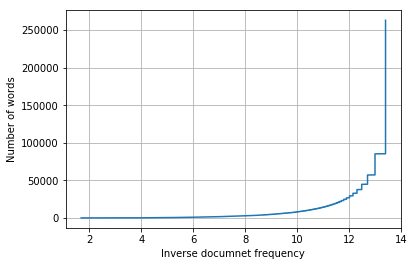

In [78]:
import matplotlib.pyplot as plt

plt.plot(sorted_word_idf_df['idf'],sorted_word_idf_df.index)
plt.ylabel("Number of words")
plt.xlabel("Inverse documnet frequency")
plt.grid()
plt.show()

observation:
    * a large number of words occurred very rare in the dataset.
    * using tf-idf vector representation for question's text will be a good choice.

Most appeared words in the questions


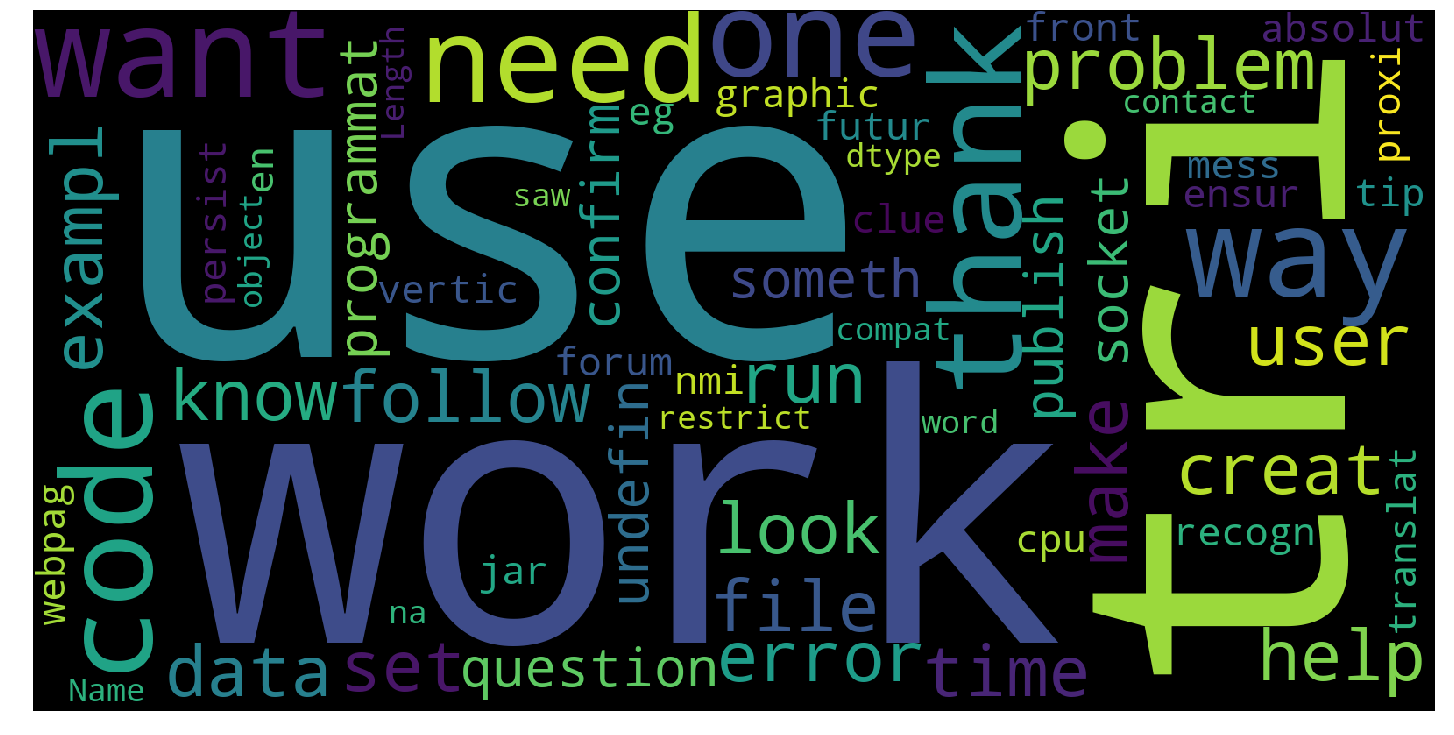

In [83]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Most appeared words in the questions")
wordcloud = WordCloud(width=1600,height=800,relative_scaling = 1).generate(str(sorted_word_idf_df['word'][0:1000]))
fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("words.png")
plt.show()

# Featurization

In [4]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

## Representation of class labels (tags)

In [5]:
#representing class labels(tags) using Count Vectorizer.

from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer3.fit_transform(preprocessed_data['tags'])

#### We will sample the number of tags instead considering all of them (due to limitation of computing power) 

In [6]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [7]:
import numpy as np
import pandas as pd
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

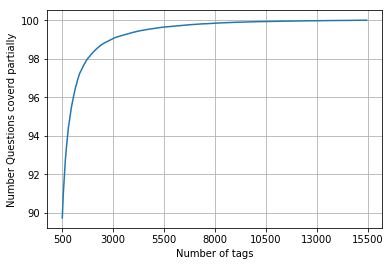

with  500 tags we are covering  89.747 % of questions


In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 49812 out of  485835


In [11]:
x_train=preprocessed_data.head(400000)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:400000,:]
y_test = multilabel_yx[400000:preprocessed_data.shape[0],:]

In [12]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (85835, 500)


## Featurization of Questions 

### Featurizing the cleaned questions using TfidfVectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

start = datetime.now()
vectorizer = TfidfVectorizer()
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:25.306776


In [14]:
if os.path.isfile('no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('no_dup.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM no_dup GROUP BY Title, Body, Tags ', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:14.857564


### Calculating the number of tags present in a question's title and body.

In [15]:
title_with_body =[]

for i in range(1,df_no_dup.shape[0]):
    value = df_no_dup['Title'].iloc[i] + df_no_dup['Tags'].iloc[i]
    title_with_body.append(value)

In [16]:
title_with_body_df = pd.DataFrame(title_with_body,columns=['Title and body'])

In [17]:
tags_occurences_in_title_with_body= vectorizer3.transform(title_with_body_df['Title and body'])

#### a function to choose the most occurred tag in a dataset

In [18]:
def tags_that_are_in_question_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    result = tags_occurences_in_title_with_body[:,sorted_tags_i[:n]] # to choose most occurred tag
    return result

In [19]:
tags_occurences_in_title_with_body_500 = tags_that_are_in_question_to_choose(500)

In [20]:
if (tags_occurences_in_title_with_body_500 != multilabel_yx).nnz  :
    print("Alright!!!! 'multilabel_yx' and 'tags_occurences_in_title_with_body_500' are NOT SAME. ")
else:
    print("Very big Error!!!")

Alright!!!! 'multilabel_yx' and 'tags_occurences_in_title_with_body_500' are NOT SAME. 


In [21]:
tags_occurences_in_title_with_body_train = tags_occurences_in_title_with_body_500[0:400000,:]
tags_occurences_in_title_with_body_test = tags_occurences_in_title_with_body_500[400000:tags_occurences_in_title_with_body_500.shape[0],:]

In [22]:
from scipy.sparse import hstack
final_features_train =hstack((x_train_multilabel, tags_occurences_in_title_with_body_train))

In [23]:
final_features_test =hstack((x_test_multilabel, tags_occurences_in_title_with_body_test))

# Modeling

## Applying Logistic Regression with OneVsRest Classifier

In [54]:
from sklearn.model_selection import GridSearchCV

start = datetime.now()

tuned_parameters = [{'estimator__alpha': [10**-8,10**-6,10**-5,10**-4,10**-3,10**-2,10**-1]}]

#Using GridSearchCV
model = GridSearchCV(OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1',max_iter=1000,tol=0.001),n_jobs=1), tuned_parameters, scoring = 'f1_micro', cv=3,n_jobs=-1,return_train_score=True)
model.fit(final_features_train,y_train )
print(model.best_estimator_)
cv_scores = pd.DataFrame(model.cv_results_)
print("Time taken to run this cell :", datetime.now() - start)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=1)
Time taken to run this cell : 1:18:54.959516


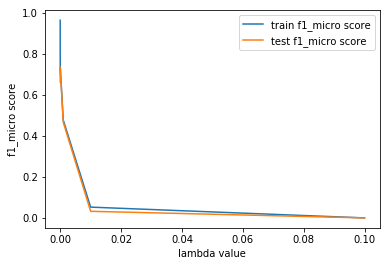

In [55]:
cv_scores2 = cv_scores.sort_values(by =['param_estimator__alpha'])
plt.plot(cv_scores2['param_estimator__alpha'],cv_scores2['mean_train_score'],label='train f1_micro score')
plt.plot(cv_scores2['param_estimator__alpha'],cv_scores2['mean_test_score'],label='test f1_micro score')
plt.xlabel('lambda value')
plt.ylabel('f1_micro score')
plt.legend()
plt.show()

In [31]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

#retraining since the kernel was interrupted
 
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=1e-05, penalty='l1', max_iter=1000,tol=0.001), n_jobs=-1)
classifier.fit(final_features_train, y_train)



predictions = classifier.predict (final_features_train)

print("Train data Accuracy :",metrics.accuracy_score(y_train, predictions))
print("Train data Hamming loss ",metrics.hamming_loss(y_train,predictions))


precision = precision_score(y_train, predictions, average='micro')
recall = recall_score(y_train, predictions, average='micro')
f1 = f1_score(y_train, predictions, average='micro')
 
print(" Train data Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_train, predictions, average='macro')
recall = recall_score(y_train, predictions, average='macro')
f1 = f1_score(y_train, predictions, average='macro')
 
print("Train data Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


print("="*100)




predictions = classifier.predict (final_features_test)

print("Test data Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Test data Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Test data Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Test data Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))



Train data Accuracy : 0.378385
Train data Hamming loss  0.00161794
 Train data Micro-average quality numbers
Precision: 0.8524, Recall: 0.6620, F1-measure: 0.7452
Train data Macro-average quality numbers
Precision: 0.8301, Recall: 0.6834, F1-measure: 0.7224
Test data Accuracy : 0.37476553853323236
Test data Hamming loss  0.0016534979903302849
Test data Micro-average quality numbers
Precision: 0.8347, Recall: 0.6705, F1-measure: 0.7436
Test data Macro-average quality numbers
Precision: 0.7947, Recall: 0.6701, F1-measure: 0.7058


## Applying Linear-SVM with OneVsRest Classifier

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import pandas as pd
from datetime import datetime

start = datetime.now()

tuned_parameters = [{'estimator__alpha': [10**-8,10**-6,10**-5,10**-4,10**-3,10**-2,10**-1]}]

#Using GridSearchCV
model = GridSearchCV(OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1',max_iter=1000,tol=0.001),n_jobs=1), tuned_parameters, scoring = 'f1_micro', cv=3,n_jobs=-1,return_train_score=True)
model.fit(final_features_train,y_train )
print(model.best_estimator_)
cv_scores = pd.DataFrame(model.cv_results_)
print("Time taken to run this cell :", datetime.now() - start)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=1)
Time taken to run this cell : 1:05:27.977670


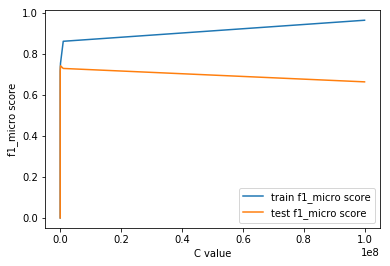

In [29]:
cv_scores2 = cv_scores.sort_values(by =['param_estimator__alpha'])
plt.plot(1/cv_scores2['param_estimator__alpha'],cv_scores2['mean_train_score'],label='train f1_micro score')
plt.plot(1/cv_scores2['param_estimator__alpha'],cv_scores2['mean_test_score'],label='test f1_micro score')
plt.xlabel('C value')
plt.ylabel('f1_micro score')
plt.legend()
plt.show()

In [33]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

predictions = model.best_estimator_.predict (final_features_train)

print("Train data Accuracy :",metrics.accuracy_score(y_train, predictions))
print("Train data Hamming loss ",metrics.hamming_loss(y_train,predictions))


precision = precision_score(y_train, predictions, average='micro')
recall = recall_score(y_train, predictions, average='micro')
f1 = f1_score(y_train, predictions, average='micro')
 
print(" Train data Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_train, predictions, average='macro')
recall = recall_score(y_train, predictions, average='macro')
f1 = f1_score(y_train, predictions, average='macro')
 
print("Train data Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


print("="*100)




predictions = model.best_estimator_.predict (final_features_test)

print("Test data Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Test data Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Test data Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Test data Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))



Train data Accuracy : 0.384015
Train data Hamming loss  0.001587395
 Train data Micro-average quality numbers
Precision: 0.8608, Recall: 0.6631, F1-measure: 0.7492
Train data Macro-average quality numbers
Precision: 0.8363, Recall: 0.6865, F1-measure: 0.7229
Test data Accuracy : 0.38347993242849654
Test data Hamming loss  0.0016087376944137006
Test data Micro-average quality numbers
Precision: 0.8458, Recall: 0.6729, F1-measure: 0.7495
Test data Macro-average quality numbers
Precision: 0.8037, Recall: 0.6743, F1-measure: 0.7071


## Applying Logistic Regression with Classifier Chain

In [24]:
y_train_dense = y_train.todense()
for y in y_train_dense:
    y = y.ravel()

In [25]:
y_test_dense = y_test.todense()
for y in y_test_dense:
    y = y.ravel()

In [26]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import SGDClassifier
from datetime import datetime

start = datetime.now()
classifier = ClassifierChain(SGDClassifier(loss='log', alpha=1e-5, penalty='l1', max_iter=1000,tol=0.001))
classifier.fit(final_features_train, y_train_dense)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:28:36.511999


In [27]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

predictions = classifier.predict (final_features_train)


print("Train data Accuracy :",metrics.accuracy_score(y_train_dense, predictions))
print("Train data Hamming loss ",metrics.hamming_loss(y_train_dense,predictions))


precision = precision_score(y_train_dense, predictions, average='micro')
recall = recall_score(y_train_dense, predictions, average='micro')
f1 = f1_score(y_train_dense, predictions, average='micro')
 
print(" Train data Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_train_dense, predictions, average='macro')
recall = recall_score(y_train_dense, predictions, average='macro')
f1 = f1_score(y_train_dense, predictions, average='macro')
 
print("Train data Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


print("="*100)


predictions = classifier.predict (final_features_test)

print("Accuracy :",metrics.accuracy_score(y_test_dense, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_dense,predictions))


precision = precision_score(y_test_dense, predictions, average='micro')
recall = recall_score(y_test_dense, predictions, average='micro')
f1 = f1_score(y_test_dense, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_dense, predictions, average='macro')
recall = recall_score(y_test_dense, predictions, average='macro')
f1 = f1_score(y_test_dense, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Train data Accuracy : 0.3918975
Train data Hamming loss  0.001615275
 Train data Micro-average quality numbers
Precision: 0.8437, Recall: 0.6728, F1-measure: 0.7486
Train data Macro-average quality numbers
Precision: 0.8193, Recall: 0.6936, F1-measure: 0.7309
Accuracy : 0.3879769324867478
Hamming loss  0.0016468573425758722
Micro-average quality numbers
Precision: 0.8282, Recall: 0.6808, F1-measure: 0.7473
Macro-average quality numbers
Precision: 0.7936, Recall: 0.6805, F1-measure: 0.7155


## Applying Linear-SVM with Classifier Chain

In [29]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import SGDClassifier
from datetime import datetime

start = datetime.now()
classifier = ClassifierChain(SGDClassifier(loss='hinge', alpha=1e-5, penalty='l1', max_iter=1000,tol=0.001))
classifier.fit(final_features_train, y_train_dense)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:24:37.714112


In [30]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

predictions = classifier.predict (final_features_train)


print("Train data Accuracy :",metrics.accuracy_score(y_train_dense, predictions))
print("Train data Hamming loss ",metrics.hamming_loss(y_train_dense,predictions))


precision = precision_score(y_train_dense, predictions, average='micro')
recall = recall_score(y_train_dense, predictions, average='micro')
f1 = f1_score(y_train_dense, predictions, average='micro')
 
print("Train data Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_train_dense, predictions, average='macro')
recall = recall_score(y_train_dense, predictions, average='macro')
f1 = f1_score(y_train_dense, predictions, average='macro')
 
print("Train data Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


print("="*100)


predictions = classifier.predict (final_features_test)

print("Test data Accuracy :",metrics.accuracy_score(y_test_dense, predictions))
print("Test data Hamming loss ",metrics.hamming_loss(y_test_dense,predictions))


precision = precision_score(y_test_dense, predictions, average='micro')
recall = recall_score(y_test_dense, predictions, average='micro')
f1 = f1_score(y_test_dense, predictions, average='micro')
 
print("Test data Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_dense, predictions, average='macro')
recall = recall_score(y_test_dense, predictions, average='macro')
f1 = f1_score(y_test_dense, predictions, average='macro')
 
print("Test data Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Train data Accuracy : 0.404945
Train data Hamming loss  0.00158255
Train data Micro-average quality numbers
Precision: 0.8502, Recall: 0.6765, F1-measure: 0.7535
Train data Macro-average quality numbers
Precision: 0.8273, Recall: 0.6979, F1-measure: 0.7314
Test data Accuracy : 0.3996155414457972
Test data Hamming loss  0.001610228927593639
Test data Micro-average quality numbers
Precision: 0.8366, Recall: 0.6832, F1-measure: 0.7522
Test data Macro-average quality numbers
Precision: 0.7953, Recall: 0.6837, F1-measure: 0.7144


# Conclusion

In [4]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer",'Model',"Multi-Label type","alpha","Train micro f1 score","Test micro f1 score"]
x.add_row(['Tfidf','Logistic Regression'," OneVsRest Classifier\n",'1e-05',' 0.7452','0.7436'])
x.add_row(['Tfidf','Linear-SVM ','OneVsRest Classifier\n','1e-05',' 0.7492','0.7495'])
x.add_row(['Tfidf','Logistic Regression',"Classifier Chain\n",'1e-05',' 0.7486','0.7473'])
x.add_row(['Tfidf','Linear-SVM ','Classifier Chain\n','1e-05',' 0.7535','0.7522'])
print(x)
print("Note: All models are implemented using SGD Classifier due to limitation of computing power and RAM.")

+------------+---------------------+-----------------------+-------+----------------------+---------------------+
| Vectorizer |        Model        |    Multi-Label type   | alpha | Train micro f1 score | Test micro f1 score |
+------------+---------------------+-----------------------+-------+----------------------+---------------------+
|   Tfidf    | Logistic Regression |  OneVsRest Classifier | 1e-05 |        0.7452        |        0.7436       |
|            |                     |                       |       |                      |                     |
|   Tfidf    |     Linear-SVM      |  OneVsRest Classifier | 1e-05 |        0.7492        |        0.7495       |
|            |                     |                       |       |                      |                     |
|   Tfidf    | Logistic Regression |    Classifier Chain   | 1e-05 |        0.7486        |        0.7473       |
|            |                     |                       |       |                    

# Procedure

* It was clear that the main objective for this bussiness problem was to predict as many tags as possible.

* Since the 7 GB train.csv file can't be loaded with the limited RAM, I had loaded only 0.5 Million of all the     data points using pandas Sqlite

* Cleaned duplicate data points in the database.

* Analysed the class labels (tags).

* Cleaned question's title and body.

* Analysed the question's title and body.

* Since it was a multi-label classification, I had represented each class label using count vectorizer.

* As 500 tags occurred in 90% of questions, I had sampled the number of tags considering the computing power.

* As most of the question's words were less frequent in the dataset, I had used Tf-idf vector representation over count vector representation(Bag of Words) for featurizing the question's text.

* As most of the tags were already present in the question's text, I had added extra features to calculate the occurances of 500 tags in each question's text using the count vectorizer instance of representing class labels(tags).

* Applied linear models like logitic regression and linear SVC, As they perform very well with large set of features.

* As it was a multi-label classification, I had implemented the models using OneVsRest Classifier and Classifier Chain.

* Since few tags occurred very less over other tags, Micro F1 score will be the best metric to choose over Macro F1 score.

* Compared all the models using pretty table.

-------------------------------------------------- THE END -------------------------------------------------------